## 1. Introduction

*This project focuses on analyzing a customer behavior analysis dataset consisting of 13 columns and 250000 rows. The dataset captures key aspects of customer interactions such as demographics, purchase behavior, product categories, payment methods, returns, and churn status. The business context revolves around understanding customer behavior, sales performance, and churn dynamics. By exploring this data, we aim to uncover actionable insights that can help improve customer retention, optimize product strategies, and maximize revenue.*

## 2. Import libraries and dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.reset_orig()

In [40]:
df = pd.read_csv("E:/Data_analyst_projects/ecommerce_customer_data.csv")
df.head()

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,46251,2020-09-08 09:38:32,Electronics,12,3,740,Credit Card,37,0.0,Christine Hernandez,37,Male,0
1,46251,2022-03-05 12:56:35,Home,468,4,2739,PayPal,37,0.0,Christine Hernandez,37,Male,0
2,46251,2022-05-23 18:18:01,Home,288,2,3196,PayPal,37,0.0,Christine Hernandez,37,Male,0
3,46251,2020-11-12 13:13:29,Clothing,196,1,3509,PayPal,37,0.0,Christine Hernandez,37,Male,0
4,13593,2020-11-27 17:55:11,Home,449,1,3452,Credit Card,49,0.0,James Grant,49,Female,1


## 3. Data Understanding & Cleaning

In [41]:
df.shape

(250000, 13)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202404 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


In [43]:
df.isnull().sum()

Customer ID                  0
Purchase Date                0
Product Category             0
Product Price                0
Quantity                     0
Total Purchase Amount        0
Payment Method               0
Customer Age                 0
Returns                  47596
Customer Name                0
Age                          0
Gender                       0
Churn                        0
dtype: int64

In [44]:
df["Returns"] = df["Returns"].replace(' ',np.nan)

In [45]:
df["Returns"] = df["Returns"].fillna(0)

In [46]:
df.columns = (df.columns.str.strip().str.lower().str.replace(' ','_'))

In [47]:
df.columns

Index(['customer_id', 'purchase_date', 'product_category', 'product_price',
       'quantity', 'total_purchase_amount', 'payment_method', 'customer_age',
       'returns', 'customer_name', 'age', 'gender', 'churn'],
      dtype='object')

In [48]:
df["purchase_date"] = pd.to_datetime(df["purchase_date"])

In [49]:
df["returns"] = df["returns"].astype(int)

In [50]:
df.dtypes

customer_id                       int64
purchase_date            datetime64[ns]
product_category                 object
product_price                     int64
quantity                          int64
total_purchase_amount             int64
payment_method                   object
customer_age                      int64
returns                           int64
customer_name                    object
age                               int64
gender                           object
churn                             int64
dtype: object

In [51]:
df.duplicated().sum()

np.int64(0)

In [52]:
df.drop(columns='age',inplace=True)

In [53]:
df["order_value"] = df["product_price"] * df["quantity"]

In [54]:
df[["product_price","quantity","order_value","customer_age"]].describe()

,product_price,quantity,order_value,customer_age
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,254.659512,2.998896,763.635756,43.940528
std,141.568577,1.414694,591.621735,15.350246
min,10.000000,1.000000,10.000000,18.000000
25%,132.000000,2.000000,290.000000,31.000000
50%,255.000000,3.000000,603.000000,44.000000
75%,377.000000,4.000000,1134.000000,57.000000
max,500.000000,5.000000,2500.000000,70.000000


In [55]:
df[["product_category","payment_method","customer_name","gender"]].describe()

,product_category,payment_method,customer_name,gender
count,250000,250000,250000,250000
unique,4,4,39920,2
top,Clothing,Credit Card,Michael Smith,Female
freq,75052,100486,107,125560


In [56]:
#check totals
df["total_match"] = np.isclose(df["total_purchase_amount"],df["order_value"],rtol=0.01)
df["total_match"].value_counts()

total_match
False    249243
True        757
Name: count, dtype: int64

In [57]:
df.drop(columns=["total_match","total_purchase_amount"],inplace=True)

In [58]:
#Changing the position of columns 
col = df.pop("order_value")
df.insert(5,"order_value",col)

In [59]:
def cov(value):
    if value == 1:
        return 'Yes'
    else:
        return 'No'

df["churn"] = df["churn"].apply(cov)

In [60]:
def cov(value):
    if value == 1:
        return 'Yes'
    else:
        return 'No'

df["returns"] = df["returns"].apply(cov)

## 4. Outlier Detection

In [61]:
# 11. Outlier Detection
def iqr_bounds(s):
    q1, q3 = s.quantile([.25,.75])
    iqr = q3 - q1
    return q1 - 1.5*iqr, q3 + 1.5*iqr

for col in ['product_price','quantity','order_value','customer_age']:
    lo, hi = iqr_bounds(df[col])
    outliers = ((df[col] < lo) | (df[col] > hi)).mean()
    outliers
    print(col, "outlier rate:", round(outliers*100,2), "%")

product_price outlier rate: 0.0 %
quantity outlier rate: 0.0 %
order_value outlier rate: 0.81 %
customer_age outlier rate: 0.0 %


In [62]:
# Get bounds
q1, q3 = df['order_value'].quantile([0.25, 0.75])
iqr = q3 - q1
lower, upper = q1 - 1.5*iqr, q3 + 1.5*iqr

# Filter outliers
outliers = df[(df['order_value'] < lower) | (df['order_value'] > upper)]
print("Outliers count:", len(outliers))

Outliers count: 2023


In [63]:
#Cap Outliers
df['order_value'] = df['order_value'].clip(lower=lower, upper=upper)

#verify if there is any ouliers left
outliers = df[(df['order_value'] < lower) | (df['order_value'] > upper)]
print("Outliers count:", len(outliers))

Outliers count: 0


## 5. Feature Engineering

In [64]:
df["year"] = df["purchase_date"].dt.year
df["month"] = df["purchase_date"].dt.to_period('M')
df["day_name"] = df["purchase_date"].dt.day_name()

In [65]:
bins = [0,25,35,50,100]
labels = ['18-25', '26-35', '36-50','51+']

df["age_group"] = pd.cut(df["customer_age"],bins=bins,labels=labels,right=True)

In [66]:
#calculating first purchase month for each customers
df['cohort_month'] = df.groupby('customer_id')['purchase_date'].transform("min").dt.to_period('M')

## 6. Univariate Analysis

In [67]:
df.columns

Index(['customer_id', 'purchase_date', 'product_category', 'product_price',
       'quantity', 'order_value', 'payment_method', 'customer_age', 'returns',
       'customer_name', 'gender', 'churn', 'year', 'month', 'day_name',
       'age_group', 'cohort_month'],
      dtype='object')

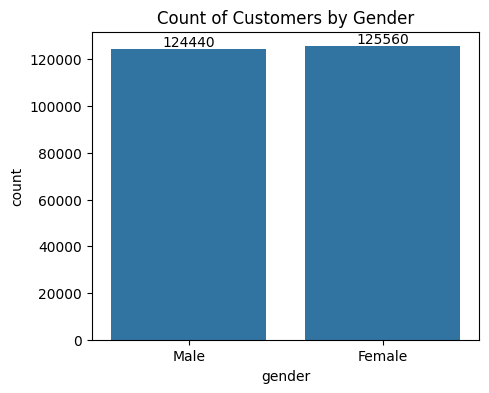

In [144]:
plt.figure(figsize=(5,4))
ax = sns.countplot(x='gender',data=df)

plt.title('Count of Customers by Gender')

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graph we can see that Most of the buyers are Females***

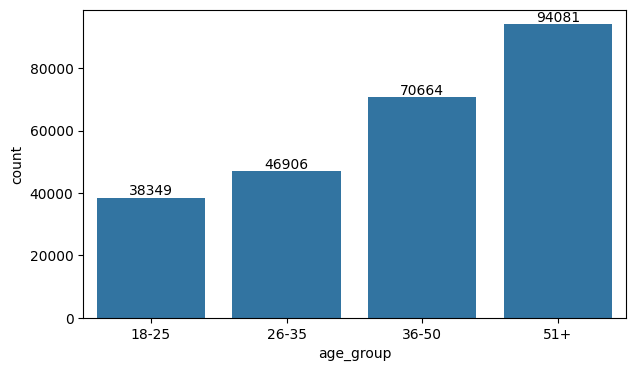

In [244]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="age_group",data=df)

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above chart we can see that age group 51+ dominates purchases***

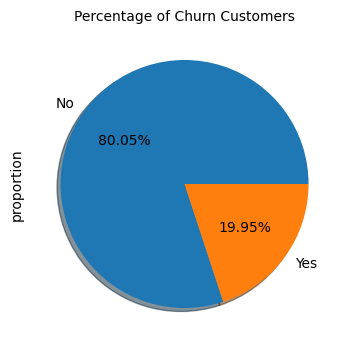

In [349]:
plt.figure(figsize=(4,5))
df["churn"].value_counts(normalize=True).plot(kind='pie',autopct='%1.2f%%',shadow=True)
plt.title("Percentage of Churn Customers",fontsize=10)
plt.show()

***From the above pie chart we can conclude that 19.95% of our customer have churned out***

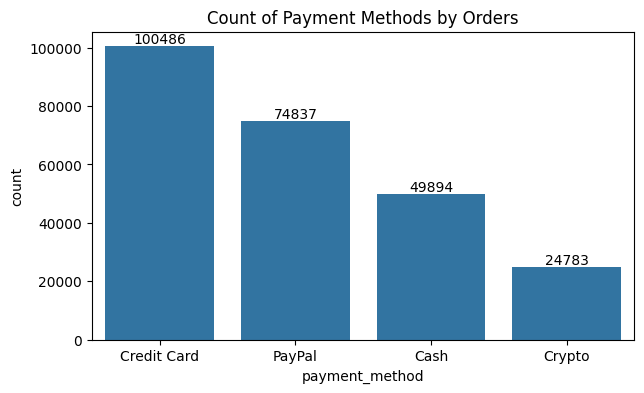

In [55]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="payment_method",data=df)
plt.title("Count of Payment Methods by Orders")

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graph we can see that most of the customers pay with Credit Card***

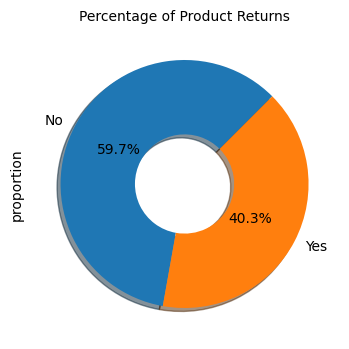

In [55]:
plt.figure(figsize=(4,5))
df["returns"].value_counts(normalize=True).plot(kind='pie',autopct='%1.1f%%',startangle=45,wedgeprops={'width':0.6},shadow=True)
plt.title("Percentage of Product Returns",fontsize=10)
plt.show()

***From the above pie chart we can see that product return rate is 40.3% Only 59.7% of purchases were retained***

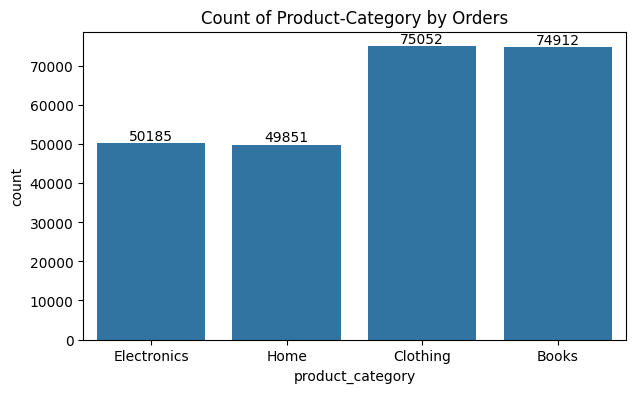

In [56]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="product_category",data=df)
plt.title("Count of Product-Category by Orders")

for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graph we can see that Clothing and Books are most buying Category***

## 7. Bivariate Analysis

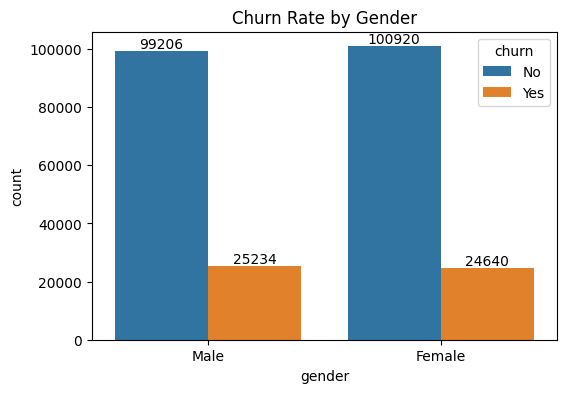

In [261]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="gender",data=df,hue='churn')
plt.title("Churn Rate by Gender")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graph we can see that Male customers show a higher churn rate compared to female customers***

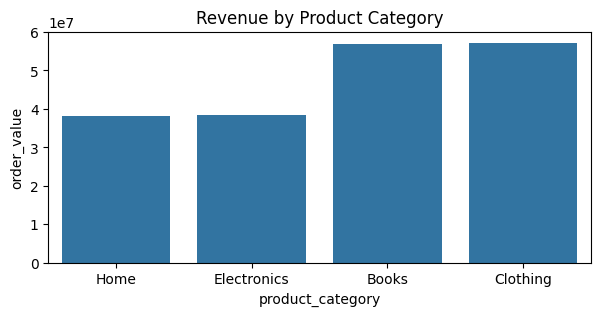

In [63]:
#Revenue by product
sales_pro = df.groupby(["product_category"],as_index=False)["order_value"].sum().sort_values(by="order_value")
plt.figure(figsize=(7,3))
sns.barplot(x="product_category",y="order_value",data=sales_pro)
plt.title("Revenue by Product Category")
plt.show()

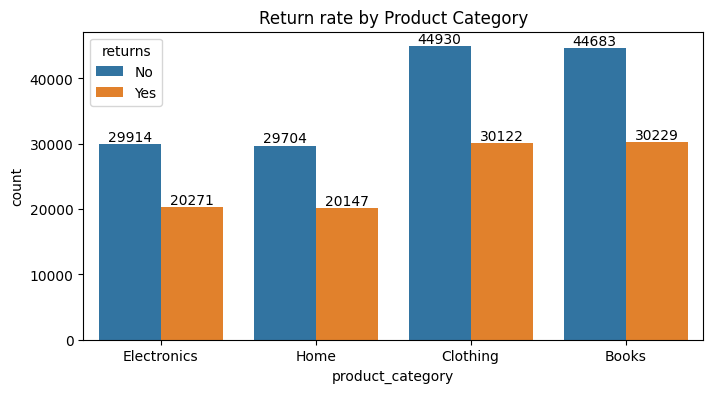

In [38]:
plt.figure(figsize=(8,4))
ax = sns.countplot(x='product_category',data=df,hue='returns')
plt.title("Return rate by Product Category")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***Clothing and Books contribute the highest sales volumes and revenues, but they also experience the highest return rates***

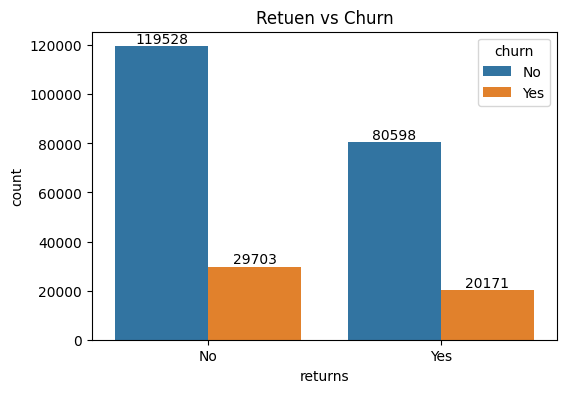

In [360]:
plt.figure(figsize=(6,4))
ax = sns.countplot(x="returns",data=df,hue='churn')
plt.title("Retuen vs Churn")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graph we can see that customers who never return products show a higher churn rate compared to those who have made returns.This suggests that product returns may not directly drive churn***

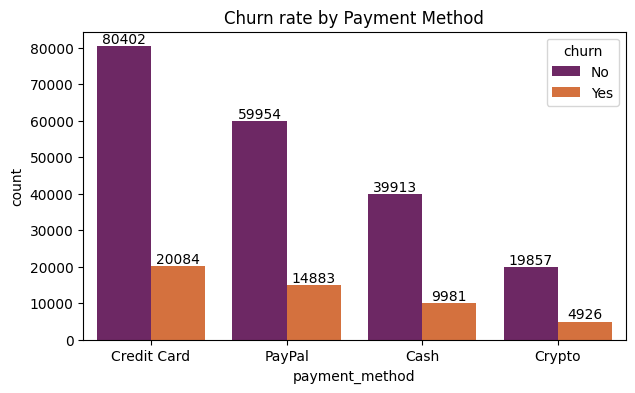

In [37]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x='payment_method',data=df,hue='churn',palette='inferno')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Churn rate by Payment Method")
plt.show()

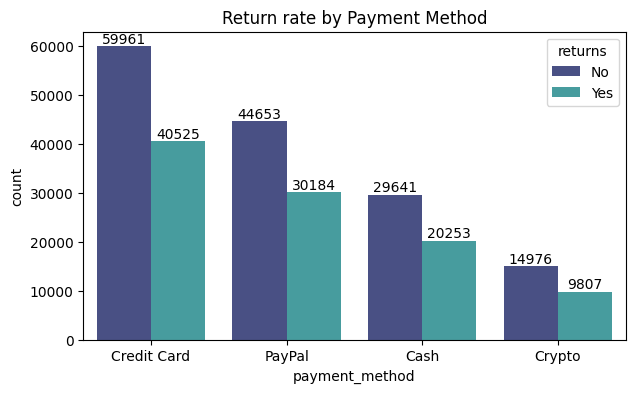

In [20]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x='payment_method',data=df,hue='returns',palette='mako')

for bars in ax.containers:
    ax.bar_label(bars)
plt.title("Return rate by Payment Method")
plt.show()

***From the above graph we can see that customers who pay via Credit Card show higher churn and return rates compared to other payment methods***

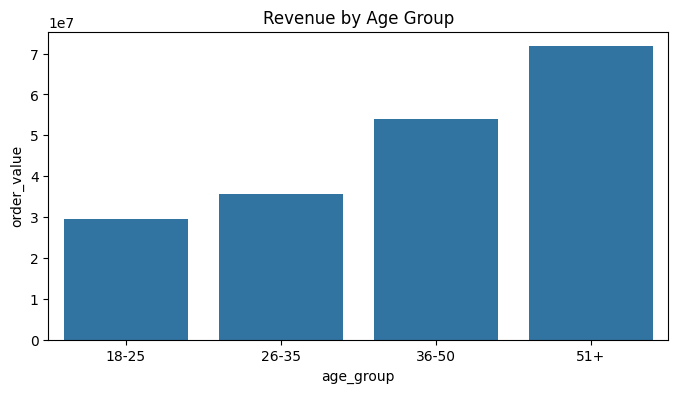

In [42]:
#Age vs order value
sales_age = df.groupby(["age_group"],as_index=False,observed=False)["order_value"].sum()
plt.figure(figsize=(8,4))
ax = sns.barplot(x="age_group",y="order_value",data=sales_age)
plt.title("Revenue by Age Group")
plt.show()

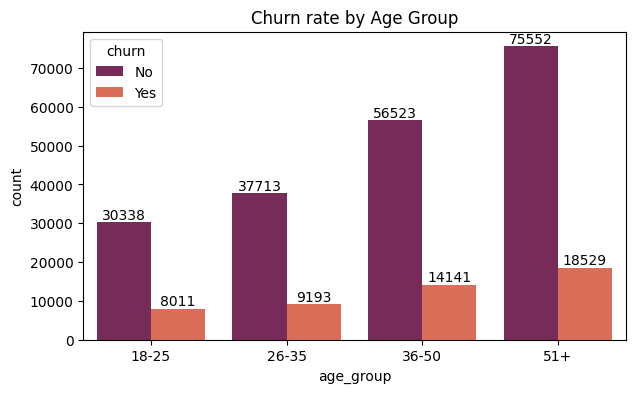

In [22]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="age_group",data=df,hue='churn',palette='rocket')
plt.title("Churn rate by Age Group")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

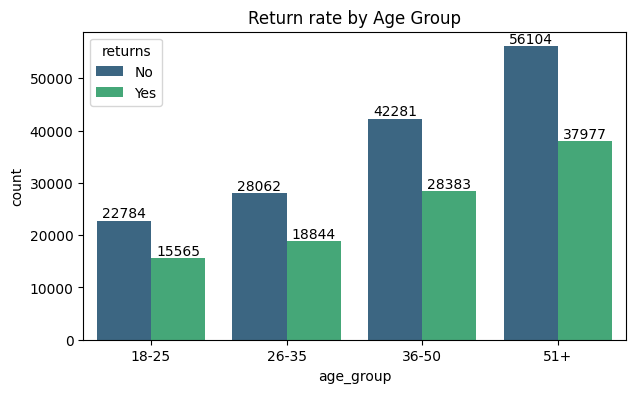

In [33]:
plt.figure(figsize=(7,4))
ax = sns.countplot(x="age_group",data=df,hue='returns',palette="viridis")
plt.title("Return rate by Age Group")
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

***From the above graphs we can see that customers aged 51+ contribute the highest sales revenue, making them a high-value customer group
and this same age group also shows the highest churn and return rate, indicating loyalty challenges***

## 8. Cohort Retention Analysis

In [30]:
# calculating how many months since the customer’s first order.
def month_diff(a,b):
    return (a.year-b.year)*12+(a.month-b.month)

df["cohort_index"] = df.apply(lambda x: month_diff(x["month"].to_timestamp(),x["cohort_month"].to_timestamp()),axis=1)

#Counts how many unique customers were active in each combination.
cohort_counts = (df.groupby(["cohort_month","cohort_index"])["customer_id"].nunique().reset_index())

#Reshape into a cohort matrix
cohort_pivot = cohort_counts.pivot(index="cohort_month",columns="cohort_index",values="customer_id")

#Calculate retention percentage
cohort_size = cohort_pivot.iloc[:,0]
retention = cohort_pivot.divide(cohort_size,axis=0)

# Keep only first 12 cohort_index (months)
cohort_12m = cohort_pivot.iloc[:, :12]

# Display
cohort_12m.head()

cohort_index,0,1,2,3,4,5,6,7,8,9,10,11
cohort_month,,,,,,,,,,,,
2020-01,5376.0,522.0,578.0,550.0,544.0,593.0,583.0,596.0,580.0,589.0,565.0,585.0
2020-02,4577.0,499.0,483.0,527.0,460.0,505.0,489.0,479.0,531.0,471.0,541.0,516.0
2020-03,4288.0,406.0,466.0,423.0,491.0,428.0,452.0,474.0,491.0,444.0,424.0,430.0
2020-04,3754.0,441.0,398.0,413.0,399.0,393.0,420.0,413.0,415.0,407.0,384.0,439.0
2020-05,3451.0,360.0,369.0,390.0,380.0,402.0,373.0,409.0,359.0,324.0,389.0,355.0


***From this we can see in Jan 2020, we had 5376 new customers. In the next month (index 1), 522 customers came back (9.7% retention). By Month 6, only 583 customers were active (10.8% of the original cohort)***

## 9. RFM Segmentation

In [38]:
max_date = df["purchase_date"].max()

rfm = df.groupby("customer_id").agg(
    recency = ("purchase_date", lambda x: (max_date - x.max()).days),
    frequency = ("purchase_date","count"),
    monetary = ("order_value","sum")
)

#RFM Score (1 = lowest, 3 = Highest)
rfm["r_score"] = pd.qcut(rfm["recency"],5,labels=[5,4,3,2,1])  #Lower is better
rfm["f_score"] = pd.qcut(rfm["frequency"],5,labels=[1,2,3,4,5])
rfm["m_score"] = pd.qcut(rfm["monetary"],5,labels=[1,2,3,4,5])

#Create Combined RFM Segment Code
rfm['rfm_score'] = rfm[['r_score','f_score','m_score']].astype(int).sum(axis=1)


#Define Customer Segments
rfm['segment'] = pd.cut(rfm['rfm_score'], bins=[2,6,9,12,15],
                        labels=['Low-Value','Mid-Value','High-Value','Champions'])

rfm.groupby(['segment'],observed=False)['monetary'].mean().sort_values(ascending=False)

segment
Champions     6688.089806
High-Value    4802.739915
Mid-Value     3194.029490
Low-Value     1817.987822
Name: monetary, dtype: float64

***Champions are more profitable and should be prioritized with retention offers.***

## 10. Key Conclusion

**High-Value Customers at Risk:**
Age 51+ group drives highest revenue but also faces highest churn & returns, requiring loyalty interventions.

**Product Dynamics:**
Clothing & Books dominate sales but suffer high return rates, reducing profitability.

**Churn & Retention:**
Overall, 20% of customers have churned. Male customers churn at higher rates compared to females. Interestingly, customers who never return products are more likely to churn, showing that product returns are not necessarily a driver of churn.

**Payment Behavior:**
Most customers prefer Credit Cards, but this method is linked to higher churn and return rates compared to others (e.g., digital wallets, COD).

**High churn after acquisition:**
Each cohort starts with several thousand customers, but only 8–12% of customers stay long-term, the majority churn after their first purchase, indicating weak onboarding or limited value in repeat purchases.

**Customer Segments:**
RFM Champions are the most profitable, while at-risk customers need targeted re-engagement.

In [32]:
df.to_csv("E:/Data_analyst_projects/ecommerce_customer_cleaned_data.csv",index=False)